Using device: cpu
[Deterministic] Epoch 050/200 | MSE: 0.2160
[Deterministic] Epoch 100/200 | MSE: 0.1750
[Deterministic] Epoch 150/200 | MSE: 0.1464
[Deterministic] Epoch 200/200 | MSE: 0.1259
[Bayesian MC] Epoch 050/200 | NLL: -0.0160
[Bayesian MC] Epoch 100/200 | NLL: -0.2577
[Bayesian MC] Epoch 150/200 | NLL: -0.3544
[Bayesian MC] Epoch 200/200 | NLL: -0.4760
Test MSE (Deterministic): 0.1512
Test MSE (Bayesian mean): 0.1944
Test Gaussian NLL (Bayesian): -0.4180
Saved figures: fig1_bnn_vs_det.png, fig2_uncertainty_decomposition.png, fig3_region_uncertainty.png, fig4_reliability_diagram.png


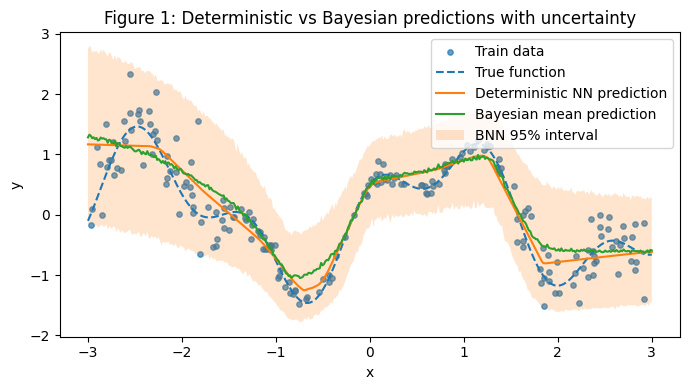

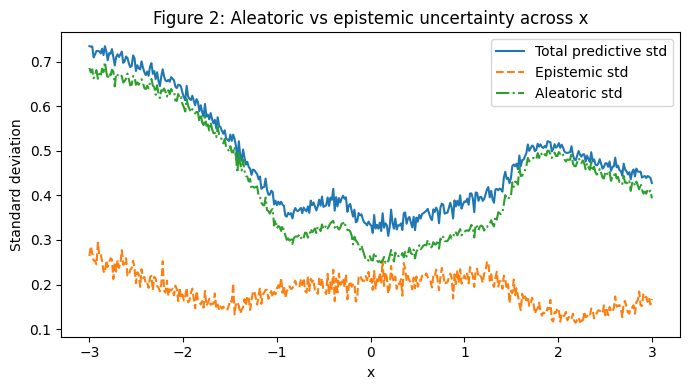

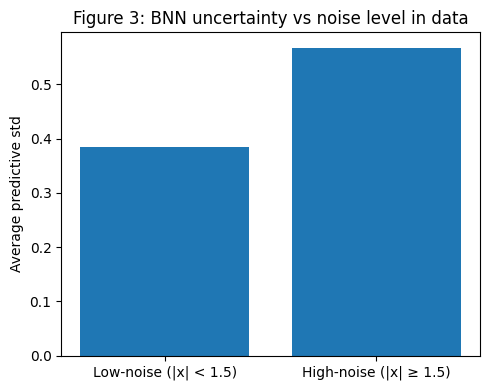

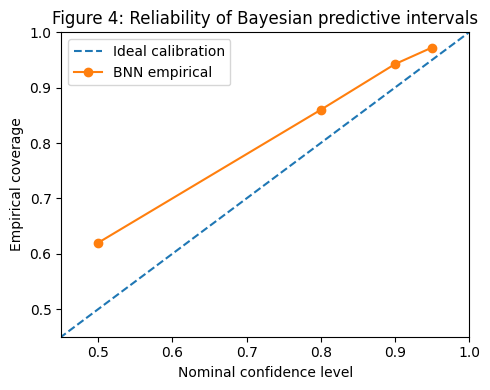

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# ----------------------------
# 1. Reproducibility & device
# ----------------------------
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------------
# 2. Synthetic regression data
# ----------------------------
def true_function(x):
    # Nonlinear smooth function
    return np.sin(2 * x) + 0.5 * np.cos(5 * x)

# Generate training data with heteroscedastic noise
n_train = 200
x_train = np.random.uniform(-3.0, 3.0, size=(n_train, 1))
y_clean = true_function(x_train)

# Low noise near the origin, high noise in the tails
noise_std = np.where(np.abs(x_train) < 1.5, 0.1, 0.4)
y_train = y_clean + noise_std * np.random.randn(n_train, 1)

x_train_t = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)

train_ds = TensorDataset(x_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

# Test grid and clean targets (for evaluation only)
x_test = np.linspace(-3.0, 3.0, 400).reshape(-1, 1)
y_test_clean = true_function(x_test)

x_test_t = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_clean_t = torch.tensor(y_test_clean, dtype=torch.float32).to(device)

# ----------------------------------------------------
# 3. Deterministic baseline network (point estimate)
# ----------------------------------------------------
class DeterministicNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

# ----------------------------------------------------
# 4. Bayesian network via MC Dropout
#    Outputs mean and log-variance (heteroscedastic)
# ----------------------------------------------------
class BayesianMCNN(nn.Module):
    def __init__(self, dropout_p=0.1):
        super().__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc_mean = nn.Linear(64, 1)
        self.fc_logvar = nn.Linear(64, 1)
        self.dropout_p = dropout_p

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        mean = self.fc_mean(x)
        log_var = self.fc_logvar(x)  # log of variance, not std
        return mean, log_var

def gaussian_nll(y_true, mean, log_var):
    """
    Gaussian negative log-likelihood for heteroscedastic regression.
    log_var is log(sigma^2).
    """
    var = torch.exp(log_var)
    return 0.5 * ((y_true - mean) ** 2 / var + log_var).mean()

# -------------------------------------------
# 5. Train deterministic and Bayesian models
# -------------------------------------------
det_model = DeterministicNN().to(device)
bayes_model = BayesianMCNN(dropout_p=0.2).to(device)

det_optim = torch.optim.Adam(det_model.parameters(), lr=1e-3)
bayes_optim = torch.optim.Adam(bayes_model.parameters(), lr=1e-3)

mse_loss = nn.MSELoss()
n_epochs = 200  # you can reduce to 100 if training is slow

# ---- Train deterministic baseline ----
for epoch in range(1, n_epochs + 1):
    det_model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        det_optim.zero_grad()
        pred = det_model(xb)
        loss = mse_loss(pred, yb)
        loss.backward()
        det_optim.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_ds)
    if epoch % 50 == 0:
        print(f"[Deterministic] Epoch {epoch:03d}/{n_epochs} | MSE: {epoch_loss:.4f}")

# ---- Train Bayesian MC network ----
for epoch in range(1, n_epochs + 1):
    bayes_model.train()
    epoch_nll = 0.0
    for xb, yb in train_loader:
        bayes_optim.zero_grad()
        mean, log_var = bayes_model(xb)
        loss = gaussian_nll(yb, mean, log_var)
        loss.backward()
        bayes_optim.step()
        epoch_nll += loss.item() * xb.size(0)
    epoch_nll /= len(train_ds)
    if epoch % 50 == 0:
        print(f"[Bayesian MC] Epoch {epoch:03d}/{n_epochs} | NLL: {epoch_nll:.4f}")

# -----------------------------
# 6. Evaluation & MC sampling
# -----------------------------
# Deterministic prediction on test grid
det_model.eval()
with torch.no_grad():
    det_pred_t = det_model(x_test_t)
det_pred = det_pred_t.cpu().numpy().reshape(-1)

# Bayesian MC predictions
bayes_model.train()  # keep dropout active for MC sampling
n_samples = 100

all_means = []
all_logvars = []

with torch.no_grad():
    for s in range(n_samples):
        mean_s, logvar_s = bayes_model(x_test_t)
        all_means.append(mean_s.cpu().numpy().reshape(-1))
        all_logvars.append(logvar_s.cpu().numpy().reshape(-1))

all_means = np.stack(all_means, axis=0)        # [S, N]
all_logvars = np.stack(all_logvars, axis=0)    # [S, N]

# Predictive components
mean_pred = all_means.mean(axis=0)                # predictive mean
epistemic_var = all_means.var(axis=0)             # across-sample variance
aleatoric_var = np.exp(all_logvars).mean(axis=0)  # data noise
total_var = epistemic_var + aleatoric_var
total_std = np.sqrt(total_var)

x_test_np = x_test.reshape(-1)
y_test_clean_np = y_test_clean.reshape(-1)

# -----------------------------
# 7. Extra evaluation metrics
# -----------------------------
# Noisy test targets (simulate new noisy obs)
noise_std_test = np.where(np.abs(x_test_np) < 1.5, 0.1, 0.4)
y_test_noisy = y_test_clean_np + noise_std_test * np.random.randn(len(x_test_np))

# Deterministic MSE on noisy test
det_mse_test = np.mean((det_pred - y_test_noisy) ** 2)

# Bayesian MSE using mean prediction
bayes_mse_test = np.mean((mean_pred - y_test_noisy) ** 2)

# Bayesian Gaussian NLL under predictive variance
bayes_nll_test = 0.5 * np.mean(
    (y_test_noisy - mean_pred) ** 2 / total_var + np.log(total_var)
)

print(f"Test MSE (Deterministic): {det_mse_test:.4f}")
print(f"Test MSE (Bayesian mean): {bayes_mse_test:.4f}")
print(f"Test Gaussian NLL (Bayesian): {bayes_nll_test:.4f}")

# -----------------------------
# 8. Four plots for the report
# -----------------------------

# FIGURE 1: Predictive mean and uncertainty band
plt.figure(figsize=(7, 4))
plt.scatter(x_train, y_train, s=15, alpha=0.7, label="Train data")
plt.plot(x_test_np, y_test_clean_np, linestyle="--", label="True function")
plt.plot(x_test_np, det_pred, label="Deterministic NN prediction")
plt.plot(x_test_np, mean_pred, label="Bayesian mean prediction")

upper = mean_pred + 2 * total_std
lower = mean_pred - 2 * total_std
plt.fill_between(x_test_np, lower, upper, alpha=0.2, label="BNN 95% interval")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Figure 1: Deterministic vs Bayesian predictions with uncertainty")
plt.legend()
plt.tight_layout()
plt.savefig("fig1_bnn_vs_det.png", dpi=300)

# FIGURE 2: Decomposition of uncertainty over input space
plt.figure(figsize=(7, 4))
plt.plot(x_test_np, total_std, label="Total predictive std")
plt.plot(x_test_np, np.sqrt(epistemic_var), linestyle="--", label="Epistemic std")
plt.plot(x_test_np, np.sqrt(aleatoric_var), linestyle="-.", label="Aleatoric std")

plt.xlabel("x")
plt.ylabel("Standard deviation")
plt.title("Figure 2: Aleatoric vs epistemic uncertainty across x")
plt.legend()
plt.tight_layout()
plt.savefig("fig2_uncertainty_decomposition.png", dpi=300)

# FIGURE 3: Average uncertainty in low- vs high-noise regions
low_noise_mask = np.abs(x_test_np) < 1.5
high_noise_mask = ~low_noise_mask

avg_std_low = total_std[low_noise_mask].mean()
avg_std_high = total_std[high_noise_mask].mean()

plt.figure(figsize=(5, 4))
regions = ["Low-noise (|x| < 1.5)", "High-noise (|x| ≥ 1.5)"]
avg_stds = [avg_std_low, avg_std_high]
plt.bar(regions, avg_stds)
plt.ylabel("Average predictive std")
plt.title("Figure 3: BNN uncertainty vs noise level in data")
plt.tight_layout()
plt.savefig("fig3_region_uncertainty.png", dpi=300)

# FIGURE 4: Reliability diagram for predictive intervals
# Confidence levels and corresponding z-scores for Gaussian
conf_levels = np.array([0.5, 0.8, 0.9, 0.95])
z_scores = np.array([0.674, 1.282, 1.645, 1.960])

coverages = []
for c, z in zip(conf_levels, z_scores):
    band = z * total_std
    covered = np.abs(y_test_noisy - mean_pred) <= band
    coverages.append(covered.mean())
coverages = np.array(coverages)

plt.figure(figsize=(5, 4))
plt.plot([0.4, 1.0], [0.4, 1.0], linestyle="--", label="Ideal calibration")
plt.plot(conf_levels, coverages, marker="o", label="BNN empirical")
plt.xlim(0.45, 1.0)
plt.ylim(0.45, 1.0)
plt.xlabel("Nominal confidence level")
plt.ylabel("Empirical coverage")
plt.title("Figure 4: Reliability of Bayesian predictive intervals")
plt.legend()
plt.tight_layout()
plt.savefig("fig4_reliability_diagram.png", dpi=300)

print("Saved figures: fig1_bnn_vs_det.png, fig2_uncertainty_decomposition.png, fig3_region_uncertainty.png, fig4_reliability_diagram.png")
